# Ablation of Latent Space (Figure 3)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rliable import library as rly
from rliable import metrics, plot_utils
import utils

In [2]:
plt.rcParams["font.size"] = 18
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["legend.loc"] = "upper left"

In [3]:
COLORS = {
    "Discrete+CE+stoch (ours)": "#984ea3",
    "Discrete+CE+det": "green",
    "Discrete+MSE": "#e41a1c",
    "SimNorm+MSE": "blue",
    "Continuous+MSE": "#ff7f00",
}
AGENTS = {
    "DCWM": "Discrete+CE+stoch (ours)",
    "FSQ+cross-entropy+mse+delta": "Discrete+CE+det",
    "FSQ+mse+standard+delta": "Discrete+MSE",
    "SimNorm+mse": "SimNorm+MSE",
    "Cont+mse+standard": "Continuous+MSE",
}
DMC_ENVS = [
    "acrobot-swingup",
    "dog-run",
    "dog-stand",
    "dog-trot",
    "dog-walk",
    "humanoid-walk",
    "humanoid-stand",
    "humanoid-run",
    "reacher-hard",
    "walker-walk",
]
MW_ENVS = [
    "mw-button-press",
    "mw-door-open",
    "mw-drawer-close",
    "mw-drawer-open",
    "mw-peg-insert-side",
    "mw-pick-place",
    "mw-push",
    "mw-reach",
    "mw-window-open",
    "mw-window-close",
]
YLABELS = {"episode_reward": "Episode Return"}

Load results of DC-MPC and baselines.

In [4]:
df = pd.read_csv("../data/ablations/latent-space.csv")

In [5]:
def plot_interval_estimates(df, verbose: bool = False):

    def check_envs():
        """Checks what seeds each agent has in each env"""
        for agent in df.agent.unique():
            for env in df.env.unique():
                agent_envs = df[df["agent"] == agent].env.unique()
                if env not in agent_envs:
                    print(f"{env} is NOT in {agent}")
                num_seeds = df[
                    (df["agent"] == agent) & (df["env"] == env)
                ].seed.unique()
                env_steps = df[
                    (df["agent"] == agent) & (df["env"] == env)
                ].env_step.unique()
                print(
                    f"seeds={np.sort(num_seeds)} for {agent} in {env}, env_step={env_steps}"
                )

    if verbose:
        check_envs()

    # Initialize an empty dictionary to store arrays for each agent
    agent_arrays = {}

    # Loop over each unique agent to create a separate array for each
    for agent in df["agent"].unique():
        # Filter the DataFrame for the current agent
        agent_df = df[df["agent"] == agent]

        # Pivot the filtered DataFrame to create a multi-indexed table with "seed" as rows, "env" and "env_step" as columns
        pivoted_df = agent_df.pivot_table(
            values="episode_reward", index="seed", columns=["env", "env_step"]
        )

        # Convert the pivoted DataFrame to a numpy array
        array = pivoted_df.to_numpy(copy=True)

        # Reshape the array based on the unique counts of "seed", "env", and "env_step"
        array = array.reshape(
            len(agent_df["seed"].unique()),
            len(agent_df["env"].unique()),
            len(agent_df["env_step"].unique()),
        )

        # Add the array to the dictionary with the agent as the key
        agent_arrays[agent] = array

    # Now agent_arrays is a dictionary where each key is an agent, and each value is the corresponding numpy array
    scores_dict = agent_arrays

    # Load ALE scores as a dictionary mapping algorithms to their human normalized
    # score matrices, each of which is of size `(num_runs x num_games)`.
    # atari_200m_normalized_score_dict = ...
    aggregate_func = lambda x: np.array(
        [
            # metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            # metrics.aggregate_mean(x),
            metrics.aggregate_optimality_gap(x),
        ]
    )
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        scores_dict, aggregate_func, reps=50000
    )

    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=[
            # "Median",
            # f"IQM MetaWorld",
            "IQM",
            # "Mean",
            "Optimality Gap",
        ],
        algorithms=list(AGENTS.values()),
        xlabel="Normalized Score",
        colors=COLORS,
        xlabel_y_coordinate=-0.15,
        row_height=0.7,
    )
    plt.subplots_adjust(wspace=0.2)

    for ax in axes:
        ax.set_xticks((0.3, 0.5, 0.7))

    return axes


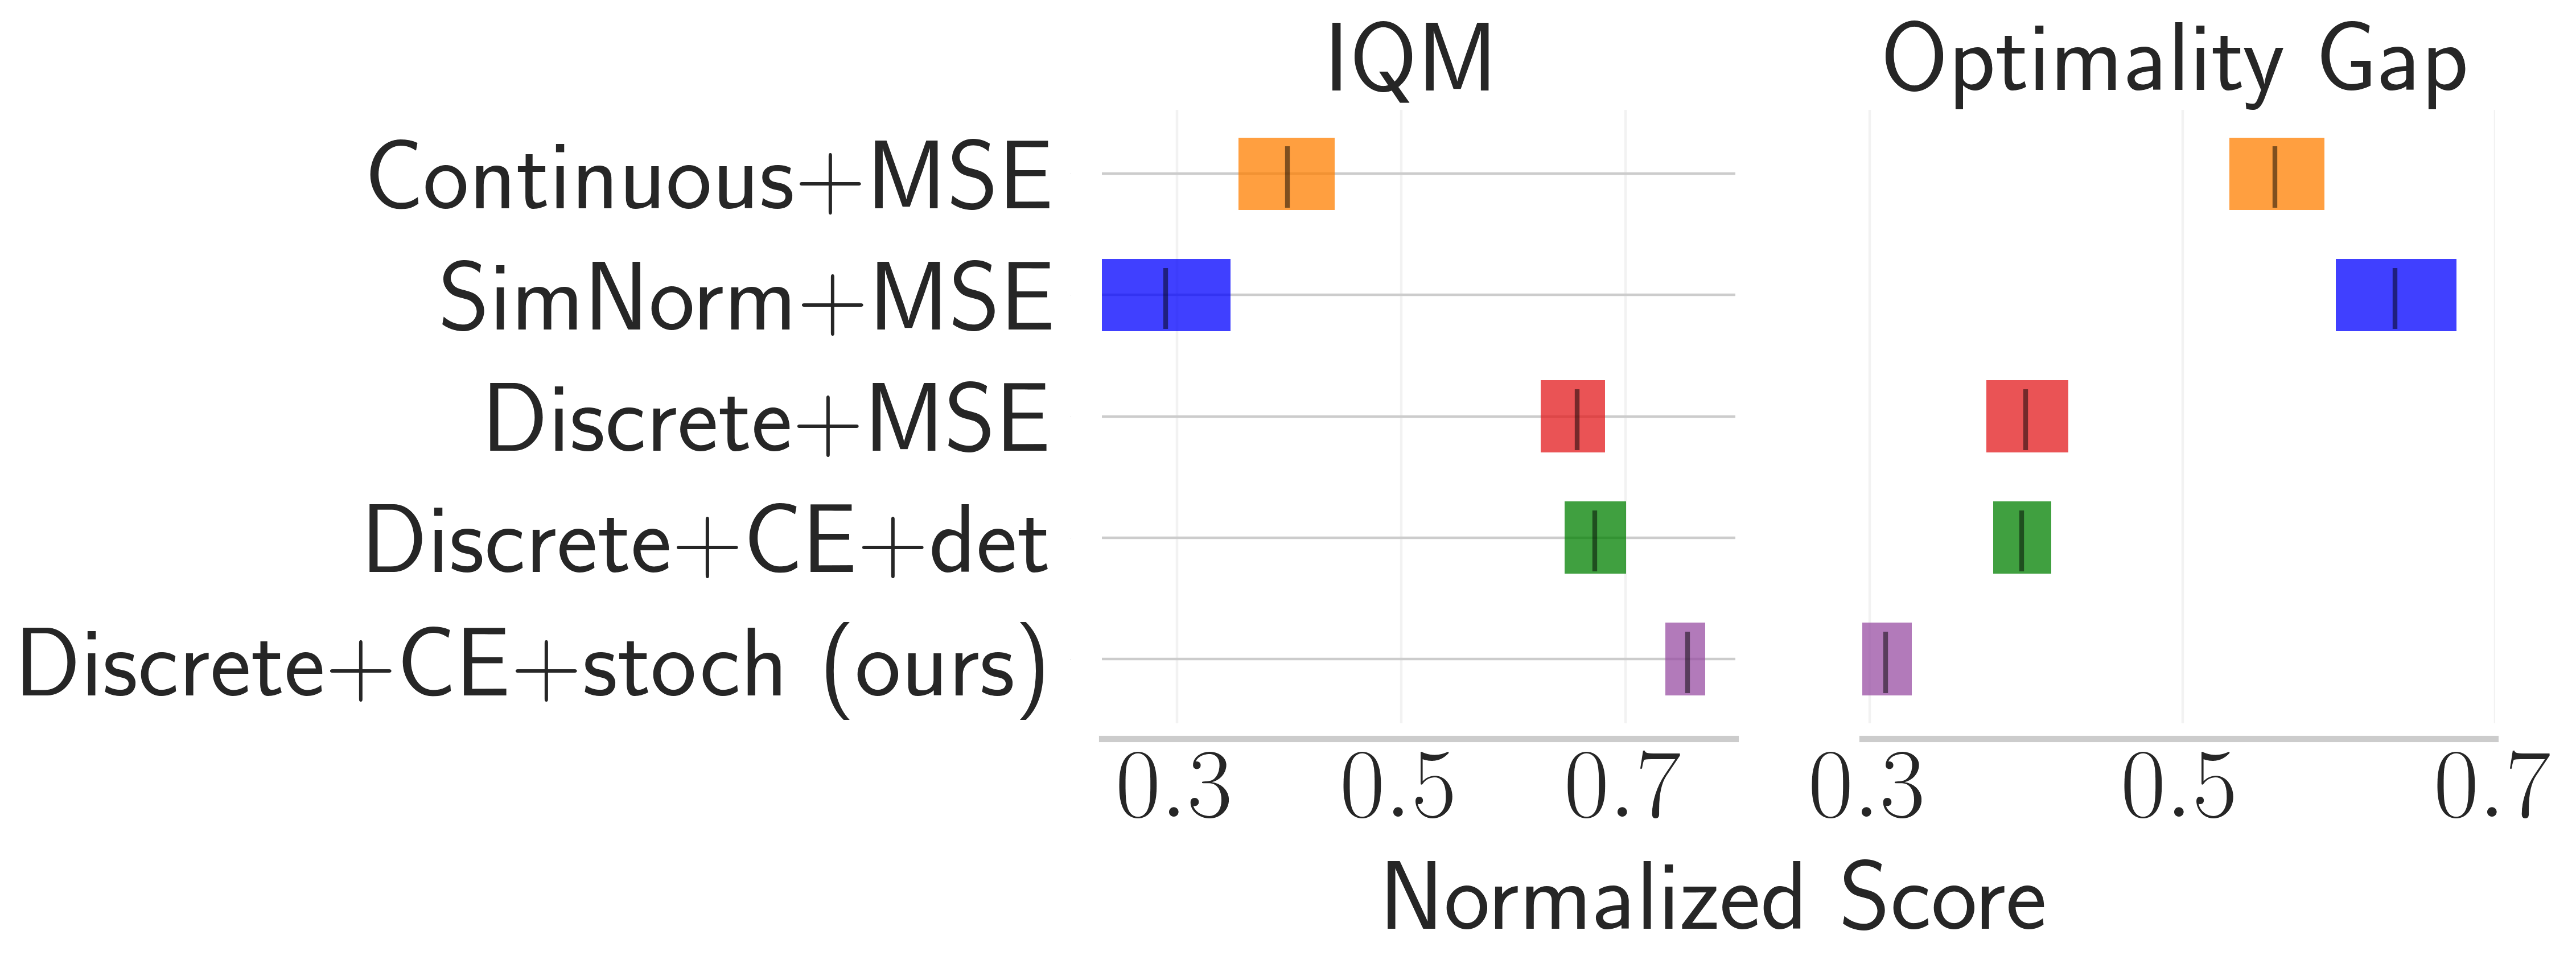

In [6]:
def plot_latent_space_ablation(df, env_step: int = 500000, verbose: bool = False):
    # Only keep desired agents and rename
    df = df[df["agent"].isin(AGENTS.keys())]
    df.loc[:, "agent"] = df["agent"].replace(AGENTS)

    ncol = 2
    nrow = 1

    # Make sure we have seed=1,2,3 for each agent/env
    # df["seed"] = df["seed"].replace({0: 3})
    SEEDS = [1, 2, 3]
    # SEEDS = [1, 2, 3, 4, 5]
    df = df[df["seed"].isin(SEEDS)]

    # Only keep desired environments
    df_dmc = df[df["env"].isin(DMC_ENVS)]
    df_dmc = df_dmc[df_dmc["env_step"] == env_step]
    df_dmc["episode_reward"] = df_dmc.apply(
        lambda row: row["episode_reward"] / 1000, axis=1
    )

    # Prepare Meta-World data frame
    df_mw = df[df["env"].isin(MW_ENVS)]
    df_mw = df_mw[df_mw["env_step"] == env_step]
    df_mw["episode_reward"] = df_mw.apply(
        lambda row: row["episode_reward"] / df_mw["episode_reward"].max(), axis=1
    )

    df_normalized = pd.concat([df_dmc, df_mw])

    axs = plot_interval_estimates(df_normalized, verbose=verbose)

    plt.savefig("./figs/latent-space-ablation-iqm-optimality-gap.pdf", bbox_inches="tight")

plot_latent_space_ablation(df, verbose=False)

In [7]:
def plot_sample_efficiency(ax, df, env_steps, env_name, max_score=None, legend=False, verbose=True):
    if max_score is None:
        max_score = df.episode_reward.max()

    def check_envs():
        """Checks what seeds each agent has in each env"""
        for agent in df.agent.unique():
            for env in df.env.unique():
                agent_envs = df[df["agent"] == agent].env.unique()
                if env not in agent_envs:
                    print(f"{env} is NOT in {agent}")
                num_seeds = df[
                    (df["agent"] == agent) & (df["env"] == env)
                ].seed.unique()
                env_steps = df[
                    (df["agent"] == agent) & (df["env"] == env)
                ].env_step.unique()
                print(
                    f"seeds={np.sort(num_seeds)} for {agent} in {env}, env_step={env_steps}"
                )

    if verbose:
        check_envs()

    # Initialize an empty dictionary to store arrays for each agent
    agent_arrays = {}

    # Loop over each unique agent to create a separate array for each
    for agent in df["agent"].unique():
        # Filter the DataFrame for the current agent
        agent_df = df[df["agent"] == agent]

        # Pivot the filtered DataFrame to create a multi-indexed table with "seed" as rows, "env" and "env_step" as columns
        pivoted_df = agent_df.pivot_table(
            values="episode_reward", index="seed", columns=["env", "env_step"]
        )

        # Convert the pivoted DataFrame to a numpy array
        array = pivoted_df.to_numpy(copy=True)

        # Normalize the scores to be in 0-1
        array = array / max_score

        # Reshape the array based on the unique counts of "seed", "env", and "env_step"
        array = array.reshape(
            len(agent_df["seed"].unique()),
            len(agent_df["env"].unique()),
            len(agent_df["env_step"].unique()),
        )

        # Add the array to the dictionary with the agent as the key
        agent_arrays[agent] = array

    scores_dict = agent_arrays

    iqm = lambda scores: np.array(
        [metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])]
    )
    iqm_scores, iqm_cis = rly.get_interval_estimates(
        scores_dict,
        iqm,
        reps=50000,
        task_bootstrap=False,
        # random_state=42,
    )
    ax = plot_utils.plot_sample_efficiency_curve(
        env_steps + 1,
        iqm_scores,
        iqm_cis,
        colors=COLORS,
        xlabel=r"Env. Steps (1e3)",
        ylabel="",
        legend=legend,
        ax=ax,
    )

    ax.set_xticks((0, 0.5e6, 1e6))
    ax.set_xticklabels(("0", "500", "1000"))

    num_tasks = len(df.env.unique())
    ax.set_title(
        f"{env_name} {num_tasks} tasks",
        # f"{env_name} ({num_tasks} tasks, {len(df.seed.unique())} seeds)",
        fontsize=30,
    )
    return ax

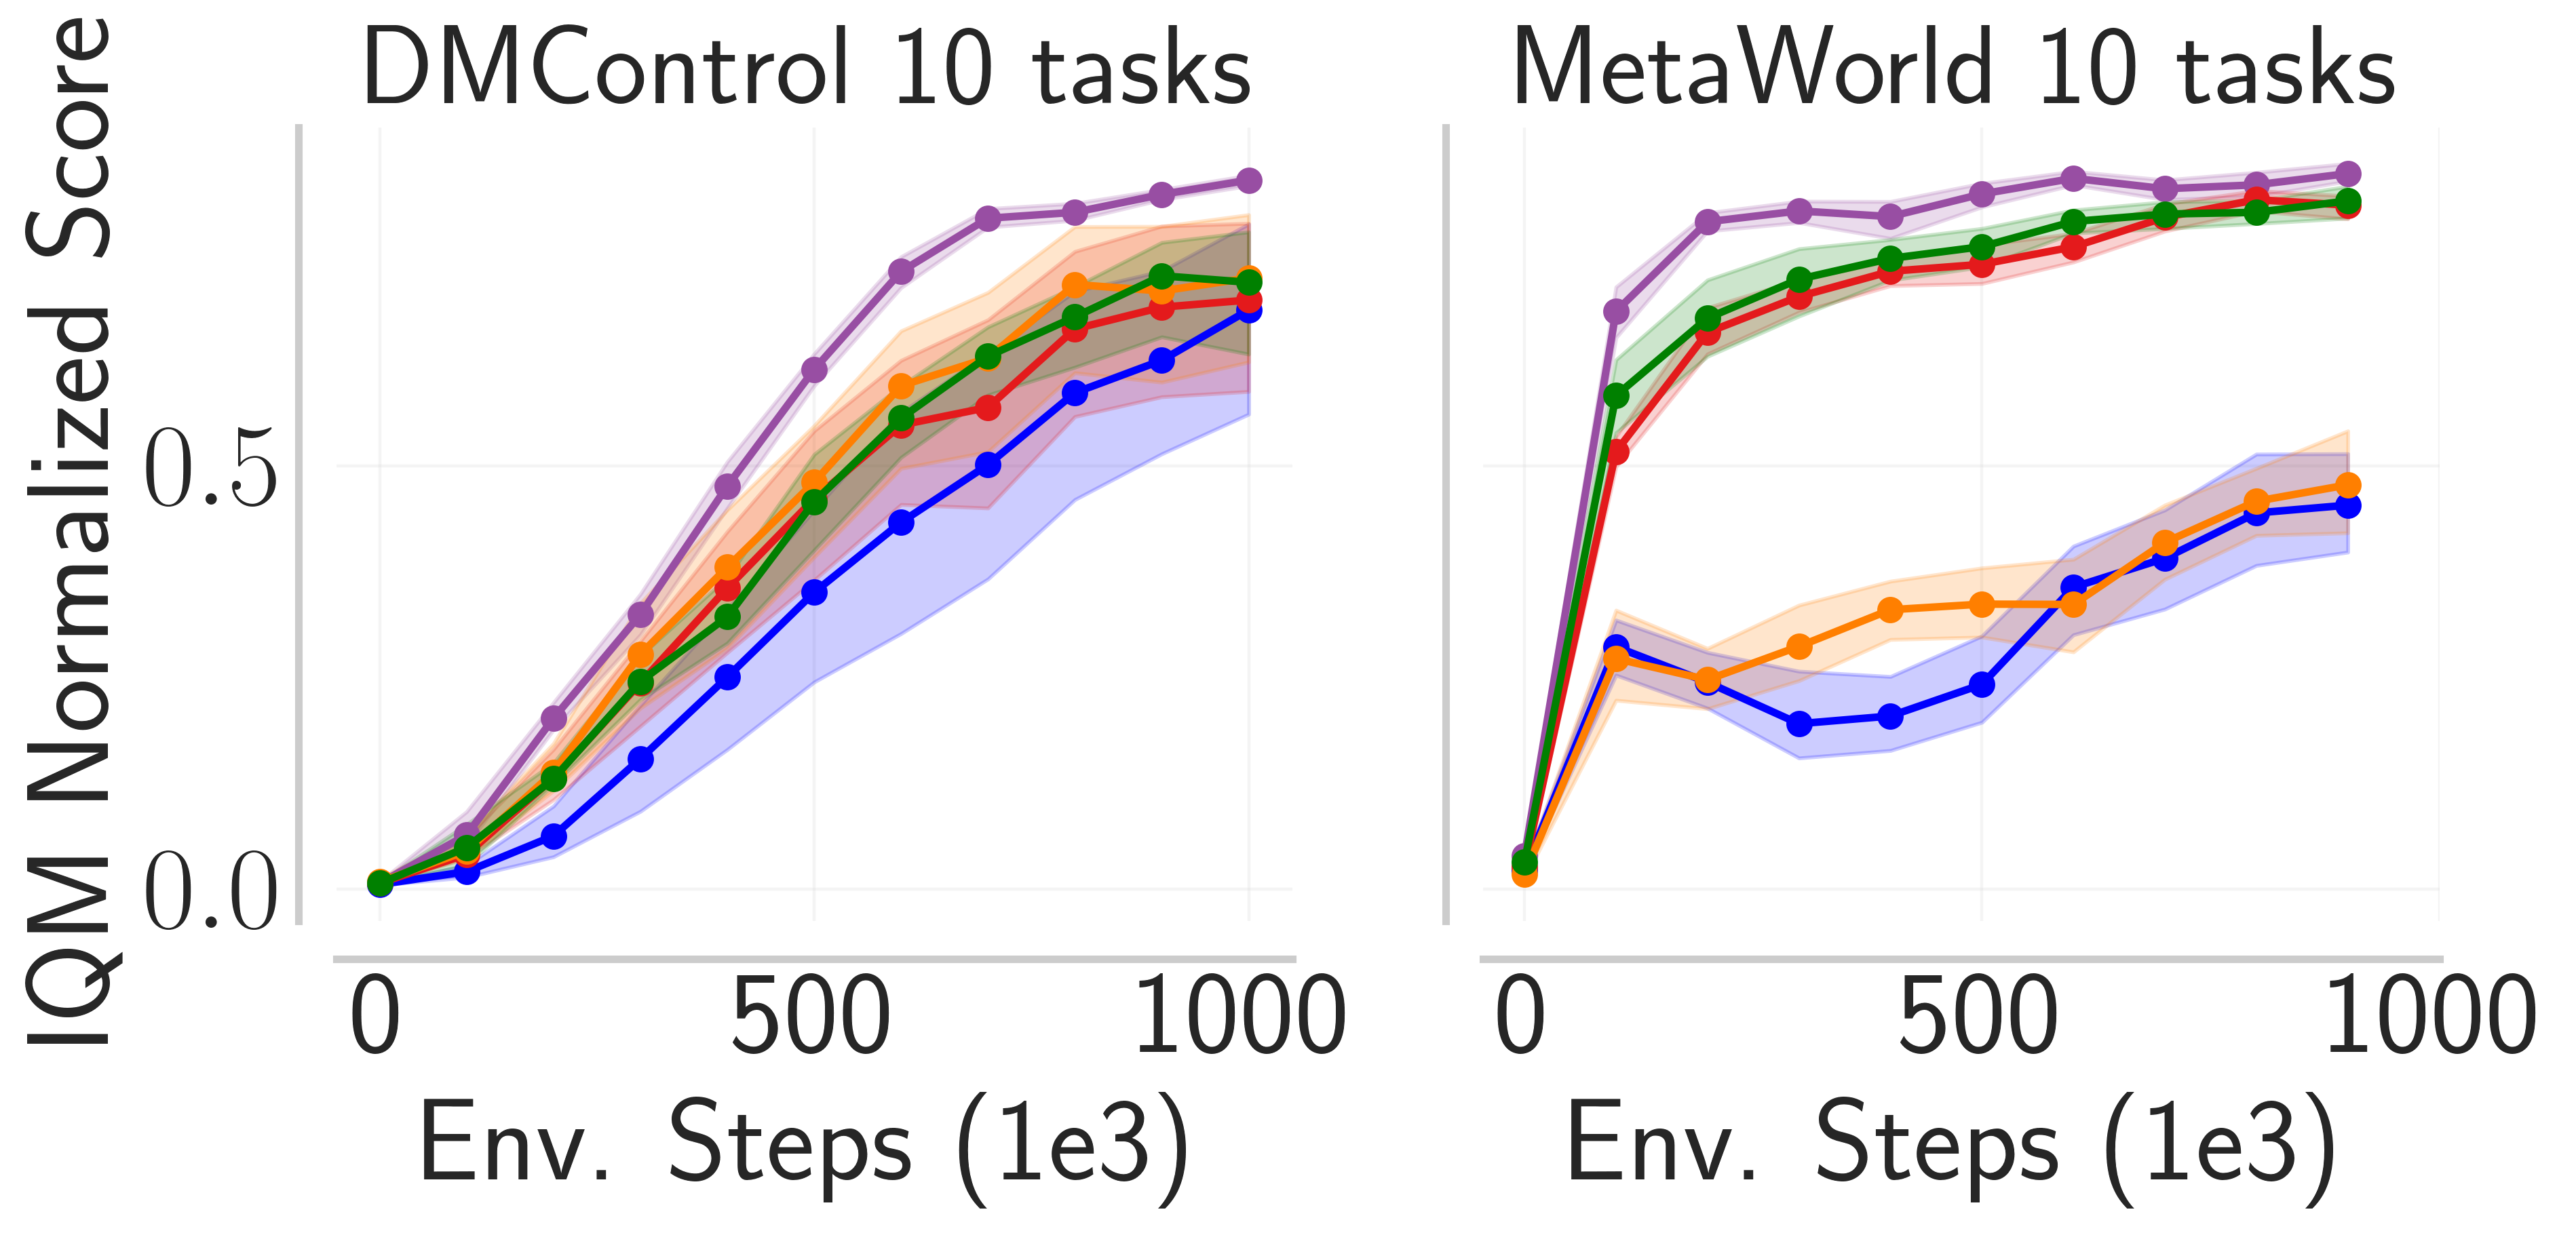

In [8]:
def plot_sample_eff(df, verbose=True):
    # Only keep desired agents
    df = df[df["agent"].isin(AGENTS.keys())]
    df.loc[:, "agent"] = df["agent"].map(AGENTS)

    ncol = 2
    nrow = 1
    fig, axs = plt.subplots(
        nrow,
        ncol,
        figsize=(5 * ncol, 3.8 * nrow),
        sharey="row",
    )

    # Make sure we have seed=1,2,3 for each agent/env
    SEEDS = [1, 2, 3]
    df = df[df["seed"].isin(SEEDS)]

    # Only keep desired environments
    df_dmc = df[df["env"].isin(DMC_ENVS)]
    DMC_ENV_STEPS = np.arange(0, 11) * 100000
    df_dmc = df_dmc[df_dmc["env_step"].isin(DMC_ENV_STEPS)]

    # Prepare Meta-World data frame
    df_mw = df[df["env"].isin(MW_ENVS)]
    MW_ENV_STEPS = np.arange(0, 10) * 100000
    df_mw = df_mw[df_mw["env_step"].isin(MW_ENV_STEPS)]


    ENV_NAMES = ["DMControl", "MetaWorld"]
    MAX_SCORES = [1000, df_mw.episode_reward.max()]
    ENV_STEPS = [DMC_ENV_STEPS, MW_ENV_STEPS]
    for i, df_env in enumerate([df_dmc, df_mw]):
        ax = plot_sample_efficiency(
            axs[i],
            df_env,
            env_steps=ENV_STEPS[i],
            env_name=ENV_NAMES[i],
            max_score=MAX_SCORES[i],
            verbose=verbose
        )

    axs[0].set_ylabel("IQM Normalized Score")

    plt.savefig(f"./figs/latent-space-ablation-sample-eff.pdf", bbox_inches="tight")

df_mw =plot_sample_eff(df, verbose=False)